In [1]:
import os
import yaml
import importlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import pyarrow.parquet as pq
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

2022-02-15 23:33:20.240028: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/MCGenerators/thepeg/2.2.1-8d929/x86_64-centos7-gcc10-opt/lib/ThePEG:/cvmfs/sft.cern.ch/lcg/releases/MCGenerators/herwig++/7.2.1-f3599/x86_64-centos7-gcc10-opt/lib/Herwig:/cvmfs/sft.cern.ch/lcg/views/LCG_101/x86_64-centos7-gcc10-opt/lib/python3.9/site-packages/torch/lib:/cvmfs/sft.cern.ch/lcg/views/LCG_101/x86_64-centos7-gcc10-opt/lib/python3.9/site-packages/tensorflow:/cvmfs/sft.cern.ch/lcg/views/LCG_101/x86_64-centos7-gcc10-opt/lib/python3.9/site-packages/tensorflow/contrib/tensor_forest:/cvmfs/sft.cern.ch/lcg/views/LCG_101/x86_64-centos7-gcc10-opt/lib/python3.9/site-packages/tensorflow/python/framework:/cvmfs/sft.cern.ch/lcg/releases/java/8u222-884d8/x86_64-centos7-gcc10-opt/jre/lib/amd64:/cvmfs/sft.cern.ch/l

In [2]:
### Parameters of the training ###

#split = "even" 
split = "odd" 
# split = even | odd -> on what split to train the model (will be in the name)
# -> you need one "odd" and one "even" models to be put inside bamboo

suffix = 'WWGGIdentifier'
# Suffix that will be added to the saved model (so multiple DNNs can be trained)

quantile = 1.0 # We will repeat the part of the weights rightmost tail
# Eg : 0.95, means we take the 5% events on the right tail of training weight and repeat them
# 1.0 means no correction (to be used if you want to diable it)

tags = ['HH','background','single H']
importance = [1.,1.,1.] # Importance of each category

# DNN hyperparameters #
parameters = {
    'epochs'                : 400,
    'lr'                    : 0.0001,
    'batch_size'            : 150,
    'n_layers'              : 4,
    'n_neurons'             : 64,
    'hidden_activation'     : 'elu',
    'output_activation'     : 'softmax',
    'l2'                    : 1e-6,
    'dropout'               : 0.,
    'batch_norm'            : True,
}
# L2 is an additional term in the loss function : l2 x ||W||**2 where ||W|| is the sum of all the DNN weights 
#    inside the neurons
# -> when overfitting the weights take large values, this tells the optimizer the trade off between performances
#    and generalization (from experience, a small value always helps)
# Dropout is a frequency of killing neurons at each batch (no backprogation for them)
# -> used generally when overfitting is detected, to avoid that the DNN learns too much 
#    (from experience, not always useful, put it when you see overfitting)
# Batch normalization is a layer that normalizes the output of each neuron (see documentation)
# -> usually helps that the gradient does not go too far and backprogation is always smooth (supposedly)
#    (from experience : always used it, maybe not worth all the time)


# Input variables
input_vars=["Eta_ph1",
            "Phi_ph1",
            "E_mGG_ph1",
            "pT_mGG_ph1",
            "Eta_ph2",
            "Phi_ph2",
            "E_mGG_ph2",
            "pT_mGG_ph2",
            "deltaPhi_DiPh",
            "deltaR_DiPh",
            "nJets",
            "nBJets",
            "bJet1_pt",
            "bJet1_eta",
            "bJet1_phi",
            "bJet1_E",
            "bJet2_pt",
            "bJet2_eta",
            "bJet2_phi",
            "bJet4_E",
            "E_jet1",   
            "pT_jet1",
            "Eta_jet1",
            "Phi_jet1", 
            "E_jet2",   
            "pT_jet2",
            "Eta_jet2",
            "Phi_jet2",  
            "E_jet3",   
            "pT_jet3",
            "Eta_jet3",
            "Phi_jet3",
            "E_jet4",   
            "pT_jet4",
            "Eta_jet4",
            "Phi_jet4",
            "w1_pT",
            "w1_eta",
            "w1_mass",
            "w2_pT",
            "w2_eta",
            "w2_mass",
            "ww_pT",
            "ww_eta",
            "ww_mass",
            "mindeltaRPJ",
            "maxdeltaRPJ",
            "deltaRJJ",
            "deltaRJJ2",
            "deltaPhi_HH",
            "deltaR_HH",
           ]

In [3]:
# Load the required data #
outputPath = '/home/ucl/cp3/sdonerta/bamboodev/WWGG/FH_Skim_08_02'
skimFile = os.path.join(outputPath,'results','Skim_FH.parquet')
yamlFile = os.path.join(outputPath,'plots.yml')
# Load dataframe from parquet #
df = pd.read_parquet(skimFile)

# Load samples + plots data from yaml file #
with open(yamlFile,'r') as handle:
    config = yaml.full_load(handle)


In [4]:
# Cut negative event weights #
df = df[(df['weight']>0) & (df['weight']<300)]
#df = df[df['weight']>0]

# Cut ttH events #
#df = df[~df.process.str.contains("GluGluToHHTo2B2G")]
#df = df[~df.process.str.contains("HHTo2G2Qlnu")]
#df = df[~df.process.str.contains("HHTo2G2l2nu")]
#df = df[~df.process.str.contains("HHTo2G2Tau")]


for i in df.process.unique():
    print(i)

GluGluToHHTo2G2Qlnu_node_cHHH1_TuneCP5_14TeV-powheg-pythia8_200PU.root
GluGluToHHTo2G2l2nu_node_cHHH1_TuneCP5_14TeV-powheg-pythia8_200PU.root
GluGluToHHTo2G2Tau_node_cHHH1_TuneCP5_14TeV-powheg-pythia8_200PU.root
GluGluToHHTo2G4Q_node_cHHH1_TuneCP5_14TeV-powheg-pythia8_200PU.root
GluGluToHHTo2B2G_node_cHHH1_TuneCP5_14TeV-powheg-pythia8_200PU.root
GluGluHToGG_M125_TuneCP5_14TeV-amcatnloFXFX-pythia8_200PU.root
VBFHToGG_M125_TuneCP5_14TeV-amcatnlo-pythia8_200PU.root
ttHJetToGG_M125_TuneCP5_14TeV-amcatnloFXFX-madspin-pythia8_200PU.root
VHToGG_M125_TuneCP5_14TeV-amcatnloFXFX-madspin-pythia8_200PU.root
THQ_ctcvcp_HToGG_M125_TuneCUETP8M1_14TeV-madgraph-pythia8_200PU.root
DiPhotonJetsBox_MGG-80toInf_14TeV-Sherpa_200PU.root
DiPhotonJetsBox_MGG-40to80_14TeV-Sherpa_200PU.root
GJet_Pt-40toInf_DoubleEMEnriched_MGG-80toInf_TuneCUEP8M2T4_14TeV_Pythia8_200PU.root
GJet_Pt-20to40_DoubleEMEnriched_MGG-80toInf_TuneCP5_14TeV-pythia8_200PU.root
WGJJToLNu_EWK_QCD_TuneCP5_14TeV-madgraph-pythia8_200PU.root
WGGJ

In [5]:
# Add tag column #
if 'tag' in df.columns:
    del df['tag']

df['tag'] = 'background'
for singleH in ['VBFH','VH','THQ','GluGluHTo','ttHJet']:
    df.loc[df.process.str.contains(singleH),['tag']] = 'single H'
for HH in ['HHTo2G2Qlnu', 'HHTo2G2l2nu', 'HHTo2G2Tau', 'HHTo2G4Q']:
    df.loc[df.process.str.contains(HH),['tag']] = 'HH'

for tag in tags:
    if tag in df.columns:
        del df[tag]

assert len(set(tags).intersection(set(pd.unique(df['tag'])))) == len(tags) # Just cross check to avoid mistakes
# Add onehot column #
label_encoder  = LabelEncoder()                                                                                                                                                              
onehot_encoder = OneHotEncoder(sparse=False)
label_encoder.fit(tags)
integers = label_encoder.transform(df['tag']).reshape(-1, 1)
onehot_encoder.fit(np.arange(len(tags)).reshape(-1, 1))
onehot = onehot_encoder.transform(integers)
onehot_df = pd.DataFrame(onehot,columns=tags,index=df.index)

df = pd.concat((df,onehot_df),axis=1)

In [6]:
#print(df)
print(df.loc[df.process.str.contains('2B2G'),['tag']])
print(df.loc[df.process.str.contains('2G4Q'),['tag']])

               tag
0       background
1       background
2       background
3       background
4       background
...            ...
133161  background
133162  background
133163  background
133164  background
133165  background

[133166 rows x 1 columns]
       tag
0       HH
1       HH
2       HH
3       HH
4       HH
...     ..
173857  HH
173858  HH
173859  HH
173860  HH
173861  HH

[173862 rows x 1 columns]


In [7]:
# Produce physical event weight #
#df['event_weight'] = pd.Series(np.zeros(df.shape[0]))
#lumi = config['configuration']['luminosity']['HL']
#for process in pd.unique(df['process']):
#    print (f'Looking at process {process}')
#    if 'cross-section' in config['files'][process].keys() and config['files'][process]['type'] != 'signal':
#         cross_section = config["files"][process]["cross-section"]
#    else:
#        cross_section = 1.
#        # For signal, we assume unit cross section (otherwise significance can be too unstable)
#    if 'branching-ratio' in config['files'][process].keys():
#        BR = config["files"][process]["branching-ratio"]
#    else:
#        BR = 1
#    if 'generated-events' in config['files'][process].keys():
#        
#        generated_events = config["files"][process]["generated-events"]
#    else:
#        raise RuntimeError('Process {process} is missing `generated-events` entry, should not happen')
#        
#    print (f'... cross-section = {cross_section}')
#    print (f'... branching-ratio = {BR}')
#    print (f'... generated-events = {generated_events}')
#    factor = lumi * cross_section * BR / generated_events
#    # We don't really care about luminosity because the scale of the weights do not matter, and you have a single lumi
#    print (f'   -> Total factor = {factor}')
#    # Apply to the new event_weight columns #
#    df.loc[df["process"]==process,'event_weight'] = df[df["process"]==process]['weight'] * factor
#    print (f'   Sum of weights = {df[df["process"]==process]["weight"].sum()} -> {df[df["process"]==process]["event_weight"].sum()}')

df['event_weight'] = df['weight'].copy()

if (df['event_weight'] < 0).sum() > 0:
    raise RuntimeError(f"There are {(df['event_weight'] < 0).sum()} events with negative event weight, this should not happen")

In [8]:
# Compute training weight #
if 'training_weight' in df.columns:
    del df['training_weight']
df['training_weight'] = df['event_weight'].copy()

for itag,tag in enumerate(tags):
    df.loc[df['tag']==tag,'training_weight'] *= importance[itag] * df.shape[0]/ len(tags) / df[df['tag']==tag]['event_weight'].sum()

    

In [9]:
#df = df[(df['weight']>0) & (df['training_weight']<200)]

In [10]:
import utils
importlib.reload(utils) # Reload in case file has changed
print ('Using event weight')
utils.checkBatches(df,label_column='tag',weight_column='event_weight',batch_size=parameters['batch_size'])
print ('Using training weight')
utils.checkBatches(df,label_column='tag',weight_column='training_weight',batch_size=parameters['batch_size'])

Using event weight
On average, per batch the total weight is
	... HH                  :     0.000636795 [26.05 events]
	... background          :    66.847515829 [26.01 events]
	... single H            :     0.471142186 [97.94 events]
Using training weight
On average, per batch the total weight is
	... HH                  :    49.995967035 [25.98 events]
	... background          :    50.864511766 [24.99 events]
	... single H            :    53.488525352 [99.03 events]


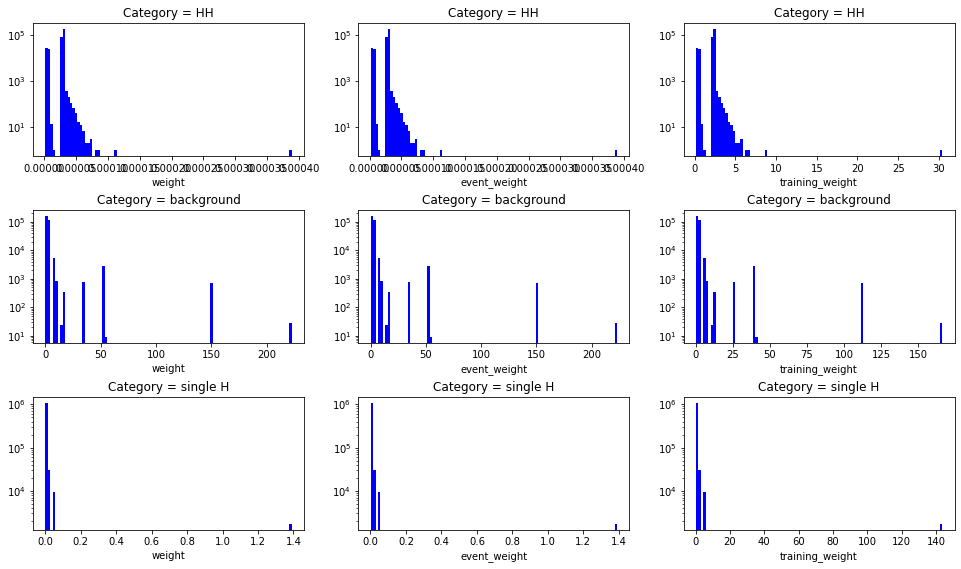

In [11]:
# Plot the background and signal weights #
fig,axs = plt.subplots(figsize=(16,8),nrows=len(tags),ncols=3)
fig.subplots_adjust(left=0.1, right=0.9, top=0.98, bottom=0.1, wspace=0.2,hspace=0.4)
for irow,tag in enumerate(tags):
    for icol,column in enumerate(['weight','event_weight','training_weight']):
        axs[irow,icol].hist(df[df['tag']==tag][column],bins=100,color='b')
        axs[irow,icol].set_title(f"Category = {tag}")
        axs[irow,icol].set_xlabel(column)
        axs[irow,icol].set_yscale('log')
fig.savefig("event_weights_A.pdf", dpi = 300)


In [12]:
# Plot the weights per process #
if False:
    with PdfPages("event_weights_B.pdf") as pdf:
        for process in pd.unique(df['process']):
            fig,axs = plt.subplots(figsize=(16,6),nrows=1,ncols=3)
            fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.2,hspace=0.3)
            fig.suptitle(f"Process {process}")
            for icol,column in enumerate(['weight','event_weight','training_weight']):
                axs[icol].hist(df[df['process']==process][column],bins=100,color='b')
                axs[icol].set_xlabel(column)
                axs[icol].set_xlim(0,(df[df['process']==process][column]).max()*1.5)
                axs[icol].set_yscale('log')
            pdf.savefig()
            plt.close(fig)

In [13]:
print(df[input_vars])

      Eta_ph1   Phi_ph1  E_mGG_ph1  pT_mGG_ph1   Eta_ph2   Phi_ph2  E_mGG_ph2  \
0    1.550125 -0.429081   2.822150    1.146218 -0.046672  0.040071   0.260259   
1   -0.331597 -0.570010   1.493106    1.414617  0.195925  0.322665   0.699442   
2   -0.010950 -2.823565   0.760817    0.760772 -1.469144 -2.621348   1.169402   
3    1.161311  1.227916   1.063237    0.606318 -0.432271 -0.724228   0.307692   
4    0.151180  2.670311   1.742575    1.722849 -0.022241 -2.667792   0.676035   
..        ...       ...        ...         ...       ...       ...        ...   
941  0.451608  2.319526   0.549398    0.497769 -1.808269 -1.826399   0.584771   
942  1.841498  1.191158   4.433098    1.371508  2.047841 -2.304103   0.733056   
943  0.348149 -2.893506   1.623579    1.529920  0.217311  1.958151   0.384663   
944 -1.360063  0.553334   1.036973    0.499375  1.025946 -1.924344   0.251422   
945 -1.950573 -2.131797   1.980870    0.552166 -0.206738  2.032132   0.266677   

     pT_mGG_ph2  deltaPhi_D

In [14]:
# Determine splitting variable #
split_var = df['Phi_ph1'].copy()
split_var = np.abs(split_var)
split_var *= 1e4
split_var -= np.floor(split_var) 
split_var = (split_var*1e1).astype(int)
split_var = split_var %2 == 0
print (f'Even set has {df[split_var].shape[0]:10d} events [{df[split_var].shape[0]/df.shape[0]*100:5.2f}%]')
print (f'Odd  set has {df[~split_var].shape[0]:10d} events [{df[~split_var].shape[0]/df.shape[0]*100:5.2f}%]')

Even set has     866917 events [50.00%]
Odd  set has     866914 events [50.00%]


In [15]:
# Sets splitting #
print (f'Using split type {split}')
# split_var = True (even number) | False (odd number)
# Name of the model is related to the even | odd quality of the events during inference (ie, in bamboo)
if split == 'even':
    train_df = df[~split_var] # Trained on odd
    test_df  = df[split_var]  # Evaluated on even 
elif split == 'odd':
    train_df = df[split_var]  # Trained on even
    test_df  = df[~split_var] # Evaluated on odd 
else:
    raise RuntimeError(f'Split needs to be either odd or even, is {split}')

# Randomize for training (always good to randomize) #
train_df = train_df.sample(frac=1)

# Quantile corrections #
# When an event has a large weight, it can imbalance a lot the training, still the weight might have a meaning
# Idea : instead of 1 event with wi>>1, we use N copies of the event with wf = wi/N
# From the point of view of the physics it does not matter, the total event weight sum of each process is the same
# From the point of view of the DNN, we have split a tough nut to crack into several smaller ones

quantile_lim = train_df['training_weight'].quantile(quantile)
print (f'{(1-quantile)*100:5.2f}% right quantile is when weight is at {quantile_lim}')
print ('  -> These events will be repeated and their learning weights reduced accordingly to avoid unstability') 

# Select the events #
idx_to_repeat = train_df['training_weight'] >= quantile_lim                          
events_excess = train_df[idx_to_repeat].copy()

saved_columns = train_df[['training_weight','process']].copy()

# Compute multiplicative factor #
factor = (events_excess['training_weight']/quantile_lim).values.astype(np.int32) 

# Correct the weights of events already in df #
train_df.loc[idx_to_repeat,'training_weight'] /= factor

# Add N-1 copies #
arr_to_repeat = train_df[idx_to_repeat].values                                       
repetition = np.repeat(np.arange(arr_to_repeat.shape[0]), factor-1)                   
df_repeated = pd.DataFrame(np.take(arr_to_repeat,repetition,axis=0),columns=train_df.columns)
df_repeated = df_repeated.astype(train_df.dtypes.to_dict()) # otherwise dtypes are object
train_df = pd.concat((train_df,df_repeated),axis=0,ignore_index=True).sample(frac=1).reset_index() # Add and randomize

# Printout #
print ('Changes per process in training set')
for process in pd.unique(train_df['process']):
    N_before = saved_columns[saved_columns['process']==process].shape[0]
    N_after  = train_df[train_df['process']==process].shape[0]
    if N_before != N_after:
        print (f"{process:20s}")
        print (f"... {N_before:6d} events [sum weight = {saved_columns[saved_columns['process']==process]['training_weight'].sum():14.6f}]",end=' -> ')
        print (f"{N_after:6d} events [sum weight = {train_df[train_df['process']==process]['training_weight'].sum():14.6f}]")
    
print ()
print (f"Total entries : {saved_columns.shape[0]:14d} -> {train_df.shape[0]:14d}")
print (f"Total event sum : {saved_columns['training_weight'].sum():14.6f} -> {train_df['training_weight'].sum():14.6f}")

# Validation split #
train_df,val_df  = train_test_split(train_df,test_size=0.3)

# Printout #
print ('\nFinal sets')
print (f'Training set   = {train_df.shape[0]}')
print (f'Validation set = {val_df.shape[0]}')
print (f'Testing set    = {test_df.shape[0]}')
print (f'Total set      = {df.shape[0]}')

Using split type odd
 0.00% right quantile is when weight is at 166.27548217773438
  -> These events will be repeated and their learning weights reduced accordingly to avoid unstability
Changes per process in training set

Total entries :         866917 ->         866917
Total event sum :  865667.437500 ->  865667.187500

Final sets
Training set   = 606841
Validation set = 260076
Testing set    = 866914
Total set      = 1733831


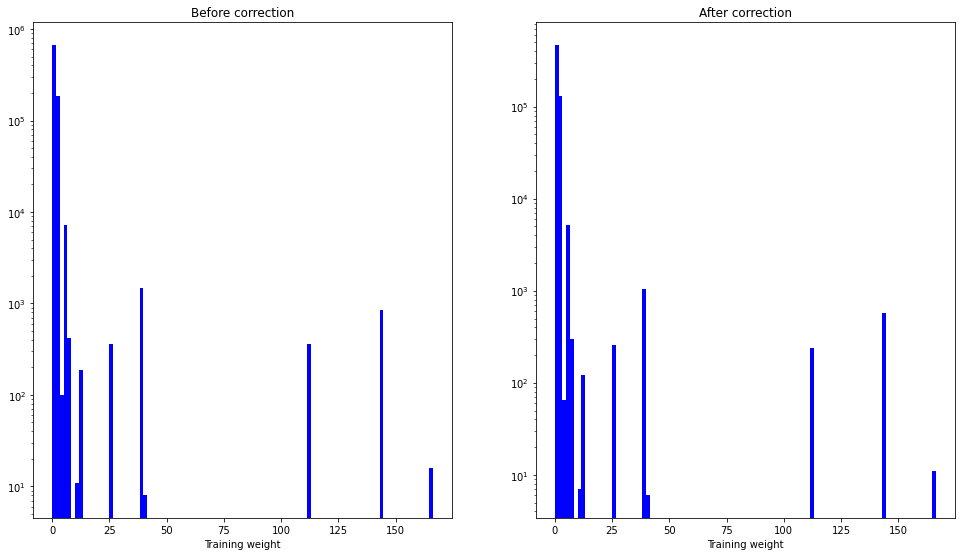

In [16]:
# Plot the background and signal weights #
fig,axs = plt.subplots(figsize=(16,8),nrows=1,ncols=2)
fig.subplots_adjust(left=0.1, right=0.9, top=0.96, bottom=0.1, wspace=0.2,hspace=0.3)

if split == 'even':
    axs[0].hist(df[~split_var]['training_weight'],bins=100,color='b')
elif split == 'odd':
    axs[0].hist(df[split_var]['training_weight'],bins=100,color='b')
axs[0].set_title("Before correction")
axs[0].set_xlabel("Training weight")
axs[0].set_yscale('log')
axs[1].hist(train_df['training_weight'],bins=100,color='b')
axs[1].set_title("After correction")
axs[1].set_xlabel("Training weight")
axs[1].set_yscale('log')
fig.savefig("event_weights_C.pdf", dpi = 300)

In [17]:
# Input layer #
inputs = keras.Input(shape=(len(input_vars),), name="particles")

# Preprocessing layer
from tensorflow.keras.layers.experimental import preprocessing
normalizer = preprocessing.Normalization(mean     = train_df[input_vars].mean(axis=0),
                                         variance = train_df[input_vars].var(axis=0),
                                         name     = 'Normalization')(inputs)
    # this layer does the preprocessing (x-mu)/std for each input
# Dense (hidden) layers #
x = normalizer
for i in range(parameters['n_layers']):
    x = layers.Dense(units                = parameters['n_neurons'], 
                     activation           = parameters['hidden_activation'], 
                     activity_regularizer = tf.keras.regularizers.l2(parameters['l2']),
                     name                 = f"dense_{i}")(x)
    if parameters['batch_norm']:
        x = layers.BatchNormalization()(x)
    if parameters['dropout'] > 0.:
        x = layers.Dropout(parameters['dropout'])(x)
# Output layer #
outputs = layers.Dense(units                = 3, 
                       activation           = parameters['output_activation'],
                       activity_regularizer = tf.keras.regularizers.l2(parameters['l2']),
                       name                 = "predictions")(x)

# Registering the model #
model = keras.Model(inputs=inputs, outputs=outputs)

2022-02-15 23:34:11.559678: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/MCGenerators/thepeg/2.2.1-8d929/x86_64-centos7-gcc10-opt/lib/ThePEG:/cvmfs/sft.cern.ch/lcg/releases/MCGenerators/herwig++/7.2.1-f3599/x86_64-centos7-gcc10-opt/lib/Herwig:/cvmfs/sft.cern.ch/lcg/views/LCG_101/x86_64-centos7-gcc10-opt/lib/python3.9/site-packages/torch/lib:/cvmfs/sft.cern.ch/lcg/views/LCG_101/x86_64-centos7-gcc10-opt/lib/python3.9/site-packages/tensorflow:/cvmfs/sft.cern.ch/lcg/views/LCG_101/x86_64-centos7-gcc10-opt/lib/python3.9/site-packages/tensorflow/contrib/tensor_forest:/cvmfs/sft.cern.ch/lcg/views/LCG_101/x86_64-centos7-gcc10-opt/lib/python3.9/site-packages/tensorflow/python/framework:/cvmfs/sft.cern.ch/lcg/releases/java/8u222-884d8/x86_64-centos7-gcc10-opt/jre/lib/amd64:/cvmfs/sft.cern.ch/lcg/views/L

In [18]:
model_preprocess = keras.Model(inputs=inputs, outputs=normalizer)
out_test = model_preprocess.predict(train_df[input_vars],batch_size=5000)
print ('Input (after normalization) mean (should be close to 0)')
print (out_test.mean(axis=0))
print ('Input (after normalization) variance (should be close to 1)')
print (out_test.var(axis=0))

2022-02-15 23:34:12.838834: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-15 23:34:12.840281: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2394070000 Hz


Input (after normalization) mean (should be close to 0)
[ 2.5240796e-08 -5.5195399e-09 -3.4547732e-08  5.3591936e-08
 -1.1148792e-08 -1.9894401e-08 -5.1266365e-08  2.1565739e-08
  2.4661377e-08 -2.0985502e-07  9.2191272e-07  1.7775006e-06
 -9.2067035e-07 -2.2153888e-08  1.0312557e-06  3.8587899e-07
 -1.0552747e-07  1.1250833e-06  3.3063083e-07  1.5195432e-07
  4.8637658e-09 -3.5322958e-07 -1.4814309e-08  3.7750137e-08
  5.1804655e-08  2.4414842e-08  1.0584782e-08 -4.7771840e-09
 -1.9931043e-09  1.5714949e-07  3.7902574e-09  4.1551491e-08
  2.5117565e-08  6.0476800e-08  2.1212829e-09  1.5109071e-08
  1.3627022e-07 -1.6858684e-09 -4.1528136e-07 -1.7084790e-08
  1.2907836e-08  1.5123639e-07  1.0874102e-07 -9.1286773e-10
 -1.5702400e-07  3.9141005e-07  9.3068968e-07  2.7624927e-07
  5.1017462e-08 -3.3273409e-08 -9.4701494e-07]
Input (after normalization) variance (should be close to 1)
[0.9997882  0.9998214  0.9997479  0.9997439  0.99978507 0.9998397
 0.99976486 0.99972564 0.9998694  0.999

In [19]:
model.compile(
    #optimizer=keras.optimizers.RMSprop(),
    optimizer=keras.optimizers.Adam(lr=parameters['lr']),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.CategoricalCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.BinaryAccuracy(),
             tf.keras.metrics.AUC(),
             tf.keras.metrics.Precision(),
             tf.keras.metrics.Recall()],
)

model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
particles (InputLayer)       [(None, 51)]              0         
_________________________________________________________________
Normalization (Normalization (None, 51)                103       
_________________________________________________________________
dense_0 (Dense)              (None, 64)                3328      
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160  

/cvmfs/sft.cern.ch/lcg/views/LCG_101/x86_64-centos7-gcc10-opt/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [20]:
# Callbacks #
early_stopping = EarlyStopping(monitor = 'val_loss',
                               min_delta = 0.001, 
                               patience = 20,
                               verbose=1,
                               mode='min',
                               restore_best_weights=True)
# Stop the learning when val_loss stops increasing 
# https://keras.io/api/callbacks/early_stopping/

reduce_plateau = ReduceLROnPlateau(monitor = 'val_loss',
                                   factor = 0.1,
                                   min_delta = 0.001, 
                                   patience = 8,
                                   min_lr = 1e-8,
                                   verbose=2,
                                   mode='min')
# reduce LR if not improvement for some time 
# https://keras.io/api/callbacks/reduce_lr_on_plateau/
import History 
importlib.reload(History)
loss_history = History.LossHistory()

In [21]:
history = model.fit(
    train_df[input_vars],
    train_df[tags],
    verbose=2,
    batch_size=parameters['batch_size'],
    epochs=parameters['epochs'],
    sample_weight=train_df['training_weight'],
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(val_df[input_vars],val_df[tags],val_df['training_weight']),
    callbacks = [early_stopping, reduce_plateau, loss_history],
)


Epoch 1/400
4046/4046 - 26s - loss: 0.9410 - binary_accuracy: 0.6388 - auc: 0.6409 - precision: 0.4366 - recall: 0.2882 - val_loss: 0.8903 - val_binary_accuracy: 0.6822 - val_auc: 0.7161 - val_precision: 0.5324 - val_recall: 0.3840
Epoch 2/400
4046/4046 - 21s - loss: 0.8595 - binary_accuracy: 0.6912 - auc: 0.7282 - precision: 0.5500 - recall: 0.4049 - val_loss: 0.8619 - val_binary_accuracy: 0.7051 - val_auc: 0.7497 - val_precision: 0.5780 - val_recall: 0.4274
Epoch 3/400
4046/4046 - 21s - loss: 0.8365 - binary_accuracy: 0.7062 - auc: 0.7486 - precision: 0.5769 - recall: 0.4449 - val_loss: 0.8599 - val_binary_accuracy: 0.7192 - val_auc: 0.7640 - val_precision: 0.6019 - val_recall: 0.4655
Epoch 4/400
4046/4046 - 20s - loss: 0.8240 - binary_accuracy: 0.7177 - auc: 0.7622 - precision: 0.5968 - recall: 0.4717 - val_loss: 0.8488 - val_binary_accuracy: 0.7165 - val_auc: 0.7633 - val_precision: 0.5948 - val_recall: 0.4690
Epoch 5/400
4046/4046 - 20s - loss: 0.8166 - binary_accuracy: 0.7182 - a

Curves saved as loss_WWGGIdentifier_odd.png


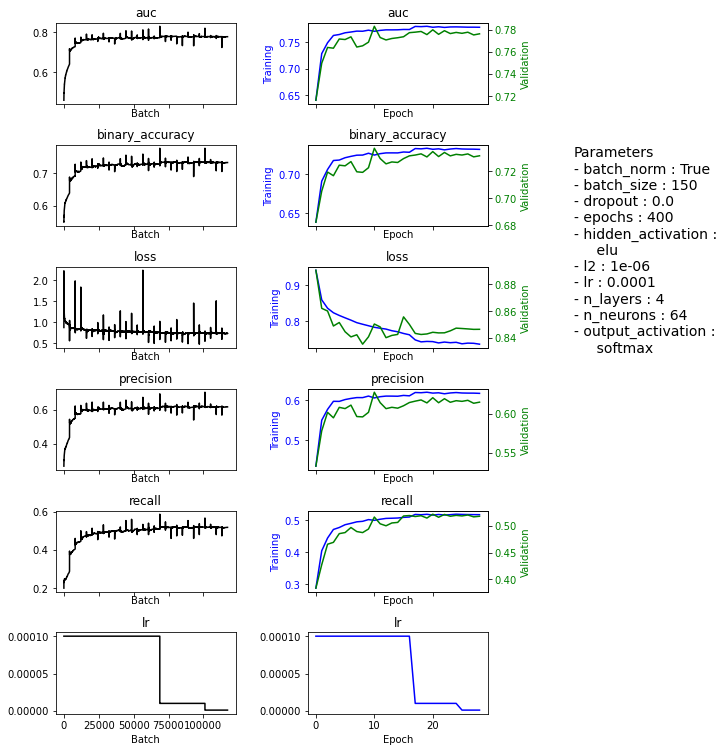

In [22]:
History.PlotHistory(loss_history,params=parameters,outputName=f'loss_{suffix}_{split}.png')
# Params is a dict of parameters with name and values
# used for plotting


In [23]:
# Produce output on the test set as new column #
output = model.predict(test_df[input_vars],batch_size=5000)
output_tags = [f'output {tag}' for tag in tags]
    # Here the batch_size arg is independent of the learning
    # Default is 32, but it can become slow, by using large value it will just compute more values in parallel
    # (more or less parallel, we are not using a GPU)
for output_tag in output_tags:
    if output_tag in test_df.columns:
        # If already output, need to remove to add again
        # avoid issues in case you run this cell multiple times
        del test_df[output_tag]

test_df = pd.concat((test_df,pd.DataFrame(output,columns=output_tags,index=test_df.index)),axis=1)
# We add the output as a column, a bit messy, different ways, here I use a concatenation

# Make the discriminator #
if 'd_HH' in test_df.columns:
    del test_df['d_HH']
    
signal_idx = [i for i,tag in enumerate(tags) if 'HH' in tag]

# d_HH = ln (P(HH) / (P(single H) + P(background)))

#test_df['d_HH'] = pd.Series(np.ones(test_df.shape[0]))

# Numerator #
num = pd.DataFrame((test_df[[output_tags[i] for i in range(len(tags)) if i in signal_idx]]).sum(axis=1))
# Denominator #
den = pd.DataFrame(test_df[[output_tags[i] for i in range(len(tags)) if i not in signal_idx]].sum(axis=1))
# Ln #
d_HH = np.log(num / den)
test_df['d_HH'] = d_HH

if df[df.isin([np.nan, np.inf, -np.inf]).any(1)].shape[0] > 0:
    raise RuntimeError('Some nan of inf values in d_HH')

ROC curve of binary classification of single H node versus all the others


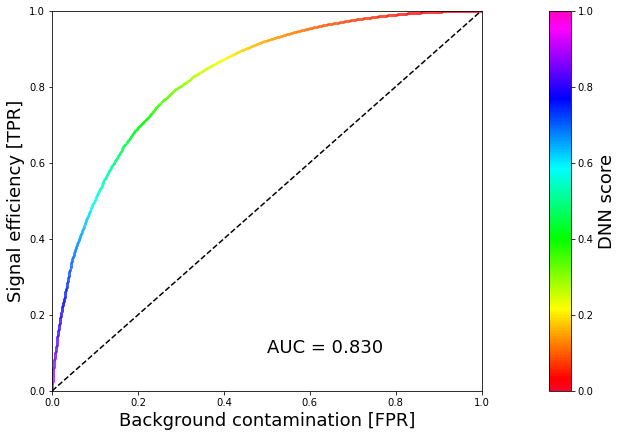

Saved ROC as roc_WWGGIdentifier_odd_HH.pdf


In [24]:
import roc
importlib.reload(roc) # Reload in case file has changed
print (f'ROC curve of binary classification of {tag} node versus all the others')
roc.rocAndSig(y_true                 = test_df['HH'],
              y_pred                 = test_df[f'output HH'],
              w_roc                  = test_df['training_weight'],
              w_sig                  = test_df['event_weight'],
              show_significance      = 'HH' in tag,
              outputName             = f'roc_{suffix}_{split}_HH.pdf')

# Multiclassification ROC curves are a bit harder to interpret than binary classification
# Here I do one versus the rest, so each ROC curves shows how the DNN is able to classify
# one class (HH, single H or background) versus all the others, which is one projection on
# how to see the performances
# For HH I show the significance but more as an information, because using only the HH node 
# means we do not use all the power of the multiclass (-> d_HH is for that)
# print (f'ROC curve of binary classification of d_HH')
# roc.rocAndSig(y_true                 = test_df['HH'],
#               y_pred                 = test_df['d_HH'],
#               w_roc                  = test_df['training_weight'],
#               w_sig                  = test_df['event_weight'],
#               show_significance      = True,
#               outputName             = f'roc_{suffix}_{split}_d_HH.pdf')

# # Tryign a new things, seeing the discrimination power of each node, class wise
# for tag in tags:
#     print (f'Multi roc curve for `output {tag}`')
#     tags_order = [tag] + [t for t in tags if t != tag]
#     roc.multiRoc(outputs    = [test_df[test_df['tag']==tag][f'output {tag}'] for tag in tags_order],
#                  tags       = tags_order,
#                  weights    = [test_df[test_df['tag']==tag]['training_weight'] for tag in tags_order],
#                  title      = f'Using node {tag}',
#                  outputName = f'multi_roc_{suffix}_{split}_output_{tag}.pdf')

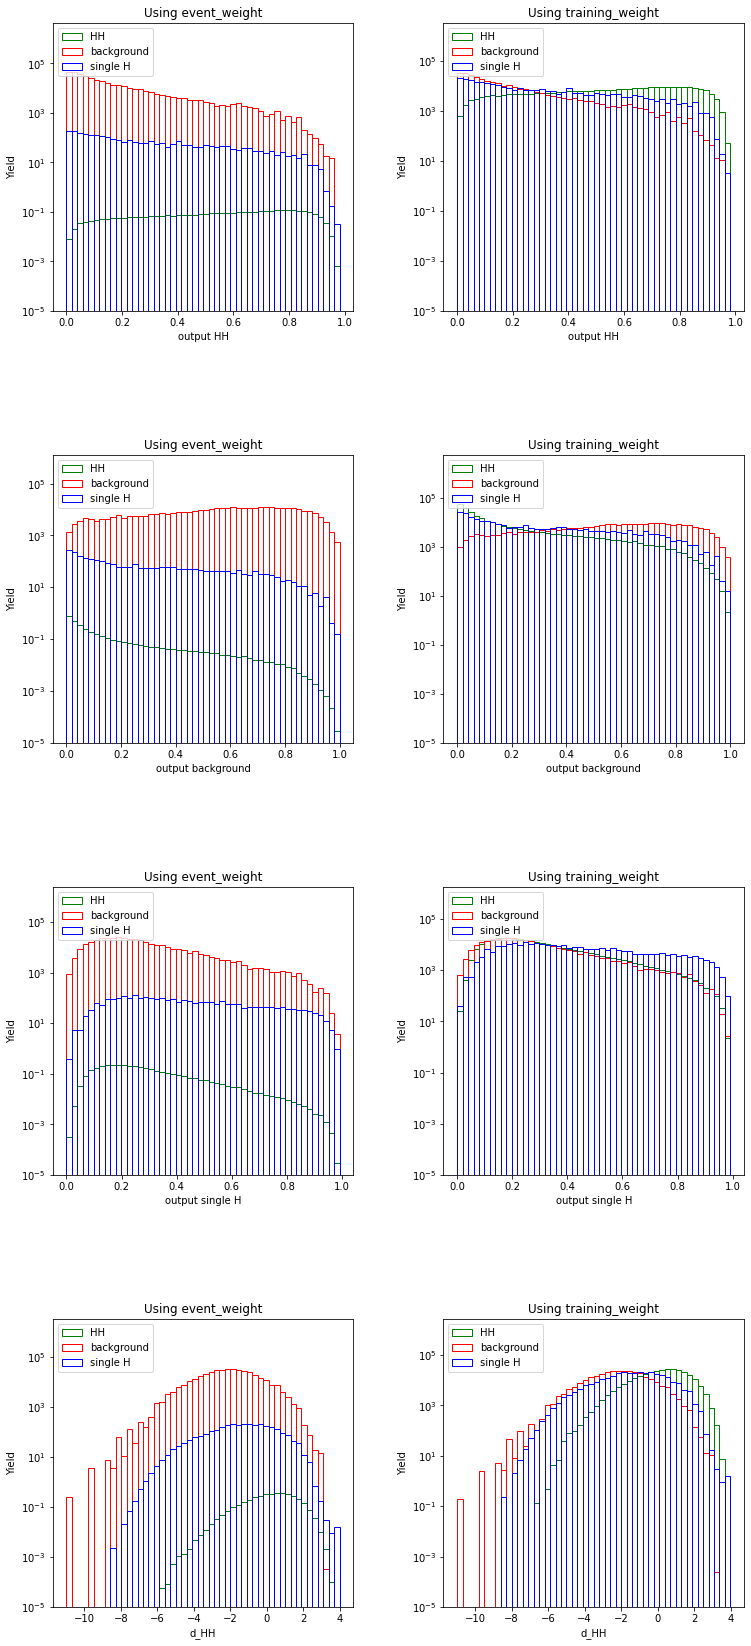

In [25]:
fig,axs = plt.subplots(figsize=(12,25),nrows=len(tags)+1,ncols=2)
fig.subplots_adjust(left=0.1, right=0.9, top=0.98, bottom=0.1, wspace=0.3,hspace=0.5)

tag_df = {tag:test_df[test_df['tag']==tag] for tag in tags}
colors = ['g','r','b']

# Manual binning so we can compute significance #
n_bins = 50

def get_bin_content(bins,y,w):
    digitized = np.digitize(y,bins)
    return np.array([w[digitized==i].sum() for i in range(1, len(bins))])

for irow,output_tag in enumerate(output_tags+['d_HH']):
    for icol,weight in enumerate(['event_weight','training_weight']):
        # Fill the bins myself #
        bins = np.linspace(test_df[output_tag].min(),test_df[output_tag].max(),n_bins+1)
        centers = (bins[1:]+bins[:-1])/2
        widths = np.diff(bins)
        
        tag_content = {tag:get_bin_content(bins,tag_df[tag][output_tag],tag_df[tag][weight])for tag in tags}
        tag_cumsum_left = {tag:np.cumsum(tag_content[tag])/tag_content[tag].sum() for tag in tags}
        tag_cumsum_right = {tag:np.cumsum(tag_content[tag][::-1])[::-1]/tag_content[tag].sum() for tag in tags}
        # Need to integrate all the bins right of the DNN cut to get significance
        #z_left = np.nan_to_num(np.sqrt(2*((cumsum_s_left+cumsum_b_left)*np.log(1+cumsum_s_left/cumsum_b_left)-cumsum_s_left)))
        #z_right = np.nan_to_num(np.sqrt(2*((cumsum_s_right+cumsum_b_right)*np.log(1+cumsum_s_right/cumsum_b_right)-cumsum_s_right)))
        #z_left /= z_left.max()
        #z_right /= z_right.max()
        for i,(tag,content) in enumerate(tag_content.items()):
            axs[irow,icol].bar(x=centers,height=content,width=widths,fill=False,edgecolor=colors[i],label=tag)     
        #ax2=axs[irow,icol].twinx()   
        
        #ax2.plot(centers,z_left,color='r',label='Significance (left of cut) [normed]')
        #ax2.plot(centers,z_right,color='r',linestyle='--',label='Significance (right of cut) [normed]')

        #for i,tag in enumerate(tag_content.keys()):
        #    ax2.plot(centers,content,color=colors[i],linestyle='-',label=f'{tag} content (left of cut)')
        #    ax2.plot(centers,color=colors[i],linestyle='--',label=f'{tag} content (right of cut)')
        
        #ax2.set_yscale("log")
        #ax2.set_ylim([0,1.4])
        #ax2.set_ylabel('Cumulative distribution')
        #ax2.legend(loc='upper right')

        axs[irow,icol].set_title(f"Using {weight}")
        axs[irow,icol].set_xlabel(output_tag)
        axs[irow,icol].set_ylabel('Yield')
        axs[irow,icol].set_ylim(1e-5,max([content.max() for content in tag_content.values()])*100)
        axs[irow,icol].set_yscale('log')
        axs[irow,icol].legend(loc='upper left')
fig.savefig(f"prediction_{suffix}_{split}.pdf", dpi = 300)

In [26]:
# evaluate the model
scores = model.evaluate(test_df[input_vars], 
                        test_df[tags], 
                        sample_weight = test_df['training_weight'], 
                        batch_size = 5000,
                        verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

174/174 - 2s - loss: 0.8406 - binary_accuracy: 0.7195 - auc: 0.7662 - precision: 0.5969 - recall: 0.4881
binary_accuracy: 71.95%


In [27]:
# save model and architecture to single file
modelName = f"model_{suffix}_{split}"
model.save(modelName)
print(f"Saved model to disk as {modelName}")

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When f

2022-02-15 23:46:39.398090: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: model_WWGGIdentifier_odd/assets
Saved model to disk as model_WWGGIdentifier_odd
